In [1]:
import torch
import argparse
import csv   
import datetime

import math
import torch.nn as nn 
from torch.nn.functional import leaky_relu, softmax
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from collections import Counter

from GANutils import *
from utils import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output

In [2]:
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

In [ ]:
data = pd.read_pickle('Data/TU_onehot')
data = back_from_dummies(data)
data = data.drop(['HomeAdrMunCode'], axis=1)
data = encode_onehot(data)

In [4]:
cat = Counter([v.split('_')[0] for v in list(data.columns)])
cat_total = sum(cat.values())
cat_n = list(cat.values())
INPUT_SIZE = 100
TARGET_NUM = len(data.columns)
GUMBEL_EPS = 1E-20
print(INPUT_SIZE, TARGET_NUM)

100 301


In [5]:
def gen_noise(size:int, batch_size:int):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn([batch_size,size]), requires_grad=False)
    return n

def softmax2onehot(x):
    x=x.to(device)
    max_idx = torch.argmax(x, 1, keepdim=True).to(device)
    one_hot = torch.FloatTensor(x.shape).to(device)
    one_hot.zero_().to(device)
    return one_hot.scatter_(1, max_idx, 1).to(device)

## Gumbel Softmax

In [6]:
def sample_gumbel(shape, eps=GUMBEL_EPS):
    unif = torch.rand(*shape).to(device)
    g = -torch.log(-torch.log(unif + eps))
    return g.to(device)

def sample_gumbel_softmax(logits, temperature):
    """
        Input:
        logits: Tensor of log probs, shape = BS x k
        temperature = scalar
        
        Output: Tensor of values sampled from Gumbel softmax.
                These will tend towards a one-hot representation in the limit of temp -> 0
                shape = BS x k
    """
    g = sample_gumbel(logits.shape)
    h = (g + logits)/temperature.to(device)
    h_max = h.max(dim=-1, keepdim=True)[0]
    h = h - h_max
    cache = torch.exp(h)
    y = cache / cache.sum(dim=-1, keepdim=True)
    return y

## Generator

In [7]:
class Generator (nn.Module):
    def __init__(self, 
                 input_size: int, 
                 hidden_size: int, 
                 temperature: float,
                 cat: Counter):
        super(Generator, self).__init__()
        self.cat = cat
        self.cat_n = list(cat.values())
        self.output_size = sum(self.cat.values())
        self.temperature = torch.Tensor([temperature]).to(device)
        self.l1 = nn.Sequential( 
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm1d(hidden_size, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(0.3)
        )
        self.l2 = nn.Sequential( 
            nn.Linear(hidden_size, hidden_size * 2),
            nn.LeakyReLU(negative_slope = 0.2),
            nn.BatchNorm1d(hidden_size * 2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(0.3)
        )
        self.l3 = nn.Sequential( 
            nn.Linear(hidden_size * 2, hidden_size * 3),
            nn.LeakyReLU(negative_slope = 0.2),
            nn.BatchNorm1d(hidden_size * 3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(0.3)
        )
        self.l4 = nn.Sequential( 
            nn.Linear(hidden_size * 3, hidden_size * 2),
            nn.LeakyReLU(negative_slope = 0.2),
            nn.BatchNorm1d(hidden_size * 2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential( 
            nn.Linear(hidden_size * 2, self.output_size))
        
    def forward(self,x):
        x=self.l1(x)
        x=self.l2(x)
        x=self.l3(x)
        x=self.l4(x)
        x=self.out(x)
        ### Softmax per class
        x = (x.split(self.cat_n, dim=1))
        out = torch.cat([sample_gumbel_softmax(v, temperature = self.temperature) for v in x], dim=1)
        return out


## Discriminator


In [8]:
class Discriminator(nn.Module):
    def __init__(self, input_size:int, output_size=1):
        '''
        input_size: size of the data
        output_size: is always 1 
        vanila: if True, Sigmoid is going to applied on the last layer
        '''
        super(Discriminator,self).__init__()
        
        self.l1 = nn.Sequential( 
            nn.Linear(input_size, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.l2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.l3 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, output_size)
        )
        
    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.out(x)
        return x
    
    def clip(self, thr):
        for p in self.parameters():
            p.data.clamp_(-thr, thr)



In [10]:
class TP_WGAN():
    def __init__(self, 
                 data, 
                 cat, 
                 epochs = 5000,
                 batch_size=64,           
                 gen_learn_rate=1E-5, # 4   
                 disc_learn_rate=1E-5, # 5
                 gamma = 10, 
                 temperature = 1E-3,
                 gen_hidden_size = 512): 
        #Data
        self.cat = cat
        self.cat_n = list(cat.values())
        self.onehot_size = sum(self.cat.values())
        self.train_val_split(data, batch_size)
        
        #Networks
        self.G = Generator(input_size=INPUT_SIZE, hidden_size=gen_hidden_size,  
                           temperature=temperature, cat=self.cat).to(device)
        self.D = Discriminator(input_size=TARGET_NUM).to(device)
        

        
        #Parameters
        self.epochs = epochs
        self.batch_size = batch_size
        self.gen_learn_rate = gen_learn_rate
        self.gen_hidden_size = gen_hidden_size
        self.disc_learn_rate = disc_learn_rate
        self.gamma = gamma
        self.temperature = temperature 

        ''''
        ADAM optimizer does not give good results 
        
        self.generator_optim = torch.optim.Adam(self.G.parameters(), gen_learn_rate, betas=(0.5, 0.999))
        self.discriminator_optim = torch.optim.Adam(self.D.parameters(), disc_learn_rate, betas=(0.5, 0.999))
    
        '''
        self.generator_optim = torch.optim.RMSprop(self.G.parameters(),
                                                  lr = self.gen_learn_rate,
                                                  centered=True)
        self.discriminator_optim = torch.optim.RMSprop(self.D.parameters(),
                                                      lr = self.disc_learn_rate,
                                            centered=True)
    
    def train_val_split(self, data, batch_size):
        train, val = train_test_split(data, test_size=0.3)
        self.train = DataLoader(torch.tensor(train.values), 
                                                batch_size=batch_size, shuffle=True, num_workers=4)
        self.val  = DataLoader(torch.tensor(val.values), 
                                                batch_size=batch_size, shuffle=True, num_workers=4)
    def sample(self, n_samples: int):
        '''
        Generate the data data with Generator network
        n_samples: usually equals to the batch size
        '''
        z = gen_noise(INPUT_SIZE, n_samples)
        z = Variable(z, requires_grad=False).to(device)
        return self.G.forward(z)

    def reset_gradient(self):
        self.D.zero_grad()
        self.G.zero_grad()
        
    def grad_penalty(self, data, generated_data):
        batch_size = data.size(0)
        epsilon = torch.rand(batch_size, TARGET_NUM)
        epsilon = epsilon.expand_as(data)
        epsilon = epsilon.to(device)

        interpolation = epsilon * data + (1 - epsilon) * generated_data
        interpolation = Variable(interpolation, requires_grad=True)
        interpolation = interpolation.to(device)

        interpolation_logits = self.D(interpolation)
        grad_outputs = torch.ones(interpolation_logits.size()).to(device)


        gradients = torch.autograd.grad(outputs=interpolation_logits,
                                  inputs=interpolation,
                                  grad_outputs=grad_outputs,
                                  create_graph=True,
                                  retain_graph=True)[0]

        gradients = gradients.view(batch_size, -1)
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)
        return self.gamma * ((gradients_norm - 1) ** 2).mean()
        
        
    def fit(self, n_critic=1, n_gen=3, to_log=True):
        filename = 'Logs/wgangp-{date:%Y-%m-%d_%H:%M:%S}'.format( date=datetime.datetime.now() )
        filename = filename.replace(':', '')
        self.log_setting(filename, n_critic, n_gen)
        self.discriminator_loss, self.generator_loss = [], []
        for epoch in range(self.epochs):
            gen_gradient = 0
            batch_d_loss, batch_g_loss = [], []
            batch_gp , batch_rs , batch_fs = [], [], []
            for x in self.val:
                ## Reset gradient for both networks (on new epoch)
                self.reset_gradient()
                a = list(self.G.parameters())[0].clone()
                a1 = list(self.G.parameters())[1].clone()
                a2 = list(self.G.parameters())[2].clone()
                a3 = list(self.G.parameters())[3].clone()
                a4 = list(self.G.parameters())[4].clone()





                x = Variable(x).float().to(device)
                ## Determine the batch size
                batch_size = x.shape[0]
                #STEP 1. TRAIN THE GENERATOR (if n_gen is larger than 1)
                if (n_gen-1)>0:
                    for _ in range(n_gen-1):
                        x_fake = self.sample(batch_size).to(device)
                        
                        output = self.D.forward(x_fake)
                        G_loss = -torch.mean(output)
                        G_loss.backward()
                        
                        self.generator_optim.step()
                        self.reset_gradient()
                        batch_g_loss.append(G_loss.item())

                        #for param in self.G.parameters():
                        #        print(param.grad.data.sum())

                        # start debugger
                        #import pdb; pdb.set_trace()


                # STEP 2. TRAIN THE DISCRIMINATOR (With gradient penalty)
                if n_critic <= 0: n_critic=1
                for _ in range(n_critic):
                    
                    output_true = self.D.forward(x)
                    # Step 2.1 Generate fake data G(z), where z ~ N(0, 1)
                    #         is a latent code.
                    x_fake = self.sample(batch_size).to(device)
                    # Step 3. Send fake data through discriminator
                    #         propagate error and update D weights.
                    # --------------------------------------------
                    # Note: detach() is used to avoid compounding generator gradients
                    output_fake = self.D.forward(x_fake.detach()) 
                    
                    gp = self.grad_penalty(x, x_fake)
                    D_loss = -(torch.mean(output_true) - torch.mean(output_fake)) + gp
                    D_loss.backward()
                    self.discriminator_optim.step()
                    
                    #Reset the gradient
                    self.reset_gradient()
                    batch_d_loss.append(D_loss.item())
                    batch_gp.append(gp.item())
                    batch_rs.append(torch.mean(output_true).item())
                    batch_fs.append(torch.mean(output_fake).item())
                
                # Step 4. Send fake data through discriminator _again_
                #         propagate the error of the generator and
                #         update G weights.
                #x_fake = self.sample(batch_size).to(device)
                #x_fake = (x_fake.split(self.cat_n, dim=1))
                #x_fake = torch.cat([sample_gumbel_softmax(v, self.temperature) for v in x_fake], dim=1)
                output = self.D.forward(x_fake)
                G_loss = -torch.mean(output)
                G_loss.backward()
                
                
                try:
                    for param in self.G.parameters():
                        gen_gradient += param.grad.data.sum()
                except:
                    print('Unstable generator')
                self.generator_optim.step()
                b = list(self.G.parameters())[0].clone()
                b1 = list(self.G.parameters())[1].clone()
                b2 = list(self.G.parameters())[2].clone()
                b3 = list(self.G.parameters())[3].clone()
                b4 = list(self.G.parameters())[4].clone()        
                batch_fs.append(torch.mean(output_fake).item())
                batch_g_loss.append(G_loss.item())
            
            self.discriminator_loss.append(np.mean(batch_d_loss))
            self.generator_loss.append(np.mean(batch_g_loss))
            clear_output()

            print("Generator gradient: %.7f" %gen_gradient, 'Weight Update %s %s %s %s %s' % (torch.equal(a.data, b.data),
                                                                                              torch.equal(a1.data, b1.data),
                                                                                              torch.equal(a2.data, b2.data),
                                                                                              torch.equal(a3.data, b3.data),
                                                                                              torch.equal(a4.data, b4.data)
                                                                                             ))            
            #### Output per epoch
     
            print("Epoch: %3d || D Loss: %5.5f (rs:%3.3f fs:%3.3f gp:%3.3f) || G Loss: %5.5f " %(epoch, 
                                                                                                 np.mean(batch_d_loss), 
                                                                                                 np.mean(batch_rs),
                                                                                                 np.mean(batch_fs),
                                                                                                 np.mean(batch_gp),
                                                                                                 np.mean(batch_g_loss)))

            # -- Plotting --
            f, axarr = plt.subplots(1, 2, figsize=(18, 7))

            # Loss
            axarr[0].set_xlabel('Epoch')
            axarr[0].set_ylabel('Loss')
            axarr[0].set_title('Discriminator Loss || lr= %s' %self.disc_learn_rate )
            axarr[1].set_xlabel('Epoch')
            axarr[1].set_ylabel('Loss')
            axarr[1].set_title('Generator Loss  || lr= %s' %self.gen_learn_rate )

            axarr[0].plot(np.arange(epoch+1), self.discriminator_loss)
            axarr[1].plot(np.arange(epoch+1), self.generator_loss, linestyle="--")
            plt.show()
            if to_log:
                self.log(filename, epoch, np.mean(batch_d_loss), np.mean(batch_g_loss), np.mean(batch_rs),
                    np.mean(batch_fs),  np.mean(batch_gp))
            print(x_fake[0])
            print(x[0])

    def synthesise(self, num=2):
        data_dummy = pd.DataFrame(columns=data.columns, dtype=np.int32)
        x_fake = self.sample(num)
        x_fake = x_fake.split(self.cat_n, dim=1)
        x_fake = torch.cat([softmax2onehot(v) for v in x_fake], dim=1)
        x_fake = np.array(x_fake.cpu())[0].astype(int)
        data_dummy.loc[-1] =np.array(x_fake)[0].astype(int)
        return back_from_dummies(data_dummy)
    def log(self, name, epoch, d_loss, g_loss, rs, fs, gp):
        fields=[epoch, d_loss, g_loss, rs, fs, gp]
        with open(r''+name + '.csv', 'a') as f:
            writer = csv.writer(f)
            writer.writerow(fields)
        if epoch % 50 == 0:
            torch.save(self.G, name)
    def log_setting(self, name, n_critic, n_gen):
        with open(r''+name+ '.txt', 'w') as f:
            f.write('BATCH NUM:  %s \n' %self.batch_size)
            f.write('Latent Space %s \n' %INPUT_SIZE)
            f.write('Target Num %s \n'%TARGET_NUM)
            f.write('D_LR %s \n' %self.disc_learn_rate)
            f.write('G_LR %s \n'%self.gen_learn_rate)
            f.write('GP Gamma %s \n' %self.gamma)
            f.write( 'Softmax T %s \n' %self.temperature)       
            f.write( 'G_hidden_size %s \n' %self.gen_hidden_size,)  
            f.write( 'G NUM %s \n' %n_gen)  
            f.write( 'C/D NUM %s \n' %n_critic)  
            f.close()

            

In [11]:
gan = TP_WGAN(data = data, cat = cat)

Generator gradient: 70927.6015625 Weight Update False False True False False
Epoch:  81 || D Loss: -1.81643 (rs:1.063 fs:-0.914 gp:0.160) || G Loss: 0.91300 


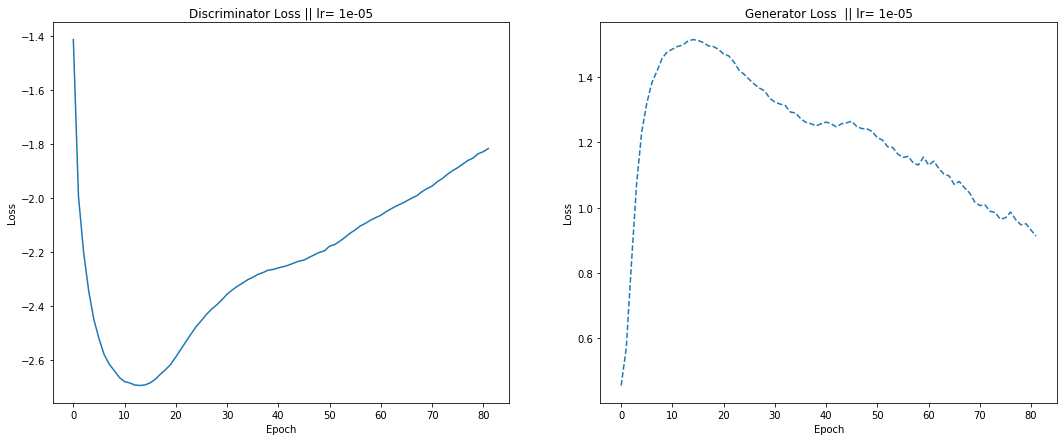

tensor([0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        6.6845e-40, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+

In [ ]:
gan.fit(n_critic=5, n_gen=1) ##add num of critics

In [ ]:
## batch size change (was the most influential part) + lr increase for generator ## remove category with too much labels
### 4 6 - got a bit down after epoch 7000
### clip the rresult

##batch normalization really helped - discriminator is tricked by gen quite fast 
### low temperature did not allow to gradient to flow throught 